In [104]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [159]:
dataset = pd.read_csv('nhefs_imp_pmm.csv')
dataset.head()

,seqnum,dead,num_rooms,income,age,race,sex,marital_status,education,weight,...,heaviest,lightest,aspirin,multivitamins,vitaminc,vitamina,vitamine,smokingcat,bmi,bmiclass
0,21886,0,5,19,31,1,2,2,41,50.119999,...,138,100,2,2,2,2,2,1,18.409550,1
1,24317,0,6,20,31,1,2,2,42,51.259998,...,149,124,1,2,2,2,2,1,18.011440,1
2,15049,1,8,13,57,1,1,3,28,44.000000,...,140,106,2,2,2,2,2,1,15.967485,1
3,3933,1,4,13,65,2,1,3,32,53.520000,...,155,109,2,2,2,2,2,3,18.324493,1
4,21890,1,1,13,64,1,1,2,25,46.720001,...,130,120,2,1,2,2,1,1,15.520434,1


In [3]:
#check for categorical value
dataset.dtypes

seqnum          int64
dead            int64
num_rooms       int64
income          int64
age             int64
               ...   
vitamina        int64
vitamine        int64
smokingcat      int64
bmi           float64
bmiclass        int64
Length: 81, dtype: object

In [4]:
dataset.isna().any().sum()

0

In [5]:
dataset["bmiclass"].value_counts()

2    6762
3    4713
4    2408
1     524
Name: bmiclass, dtype: int64

# Random Forest

In [204]:
X = dataset.loc[:,dataset.columns != 'bmiclass']
y = dataset["bmiclass"]
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)

In [109]:
rf_200 = RandomForestClassifier(n_estimators=200, random_state=42,max_features='auto')
rf_200.fit(X_train,y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [110]:
y_train_pred_200 = rf_200.predict(X_train)
print('random forest model training accuracy score with 200 decision tree: {0:0.4f}'. format(accuracy_score(y_train, y_train_pred_200)))
y_test_pred_200 = rf_200.predict(X_test)
print('random forest model testing accuracy score with 200 decision tree: {0:0.4f}'. format(accuracy_score(y_test, y_test_pred_200)))

random forest model training accuracy score with 200 decision tree: 1.0000
random forest model testing accuracy score with 200 decision tree: 0.9951


In [111]:
confusion_matrix(y_test,y_test_pred_200)

array([[ 103,   10,    0,    0],
       [   0, 1335,    0,    0],
       [   0,    0,  971,    0],
       [   0,    0,    4,  459]])

In [114]:
importance = rf_200.feature_importances_
importance_std = np.std([tree.feature_importances_ for tree in rf_200.estimators_], axis=0)

<BarContainer object of 80 artists>

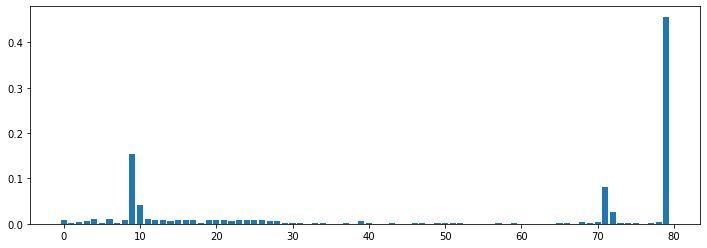

In [132]:
plt.figure(figsize = (12,4))
importance = pd.Series(importance)
plt.bar(x = range(80),height = importance)

In [195]:
importance_index = [i for i in range(80) if importance[i] >= 0.001]
len(importance_index)

45

# GAM

In [11]:
!pip install pygam
from pygam import LogisticGAM

In [196]:
importance_index.append(80)
dataset_dropped = dataset.iloc[:,importance_index]

In [197]:
dataset_dropped.shape

(14407, 46)

In [199]:
#we have to use a one-versus-all structure since GAM is suitable for binary classification but we have 4 classes
#four_class_probs = np.empty([])
class_1_probabilities = []
class_2_probabilities = []
class_3_probabilities = []
class_4_probabilities = []
temp = 10
for i in range(4):
    cls = i + 1
    dataset_class = dataset_dropped.copy()
    dataset_class.loc[dataset_class["bmiclass"] == cls,"bmiclass"] = temp
    dataset_class.loc[dataset["bmiclass"] != cls,"bmiclass"] = 0
    dataset_class.loc[dataset_class["bmiclass"] == temp,"bmiclass"] = 1
    X = dataset_class.loc[:,dataset_class.columns != 'bmiclass']
    y = dataset_class["bmiclass"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    gam = LogisticGAM(lam = 0.6).fit(X_train, y_train)
    class_probabilities = gam.predict_proba(X_test)
    print(class_probabilities)
    if i == 0:
        class_1_probabilities = class_probabilities
    elif i == 1:
        class_2_probabilities = class_probabilities
    elif i == 2:
        class_3_probabilities = class_probabilities
    else:
        class_4_probabilities = class_probabilities
    #four_class_probs = np.hstack((four_class_probs,class_probabilities)) if four_class_probs.size else class_probabilities

/Users/mittyhainan/opt/anaconda3/lib/python3.8/site-packages/pygam/links.py:149: RuntimeWarning: divide by zero encountered in true_divide
  return dist.levels/(mu*(dist.levels - mu))
/Users/mittyhainan/opt/anaconda3/lib/python3.8/site-packages/pygam/pygam.py:591: RuntimeWarning: invalid value encountered in multiply
  return sp.sparse.diags((self.link.gradient(mu, self.distribution)**2 *
/Users/mittyhainan/opt/anaconda3/lib/python3.8/site-packages/pygam/links.py:149: RuntimeWarning: overflow encountered in true_divide
  return dist.levels/(mu*(dist.levels - mu))
/Users/mittyhainan/opt/anaconda3/lib/python3.8/site-packages/pygam/pygam.py:591: RuntimeWarning: overflow encountered in square
  return sp.sparse.diags((self.link.gradient(mu, self.distribution)**2 *
/Users/mittyhainan/opt/anaconda3/lib/python3.8/site-packages/pygam/links.py:133: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/Users/mittyhainan/opt/anaconda3/lib/python3.8/site-packages/pygam/links.py:134: Runt

did not converge
[1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
 3.76107416e-30 1.00000000e+00]


/Users/mittyhainan/opt/anaconda3/lib/python3.8/site-packages/pygam/pygam.py:591: RuntimeWarning: overflow encountered in square
  return sp.sparse.diags((self.link.gradient(mu, self.distribution)**2 *


[1.60334941e-14 9.99450524e-01 2.13251901e-12 ... 1.87131612e-24
 1.97457233e-02 1.86792772e-24]


/Users/mittyhainan/opt/anaconda3/lib/python3.8/site-packages/pygam/pygam.py:591: RuntimeWarning: overflow encountered in square
  return sp.sparse.diags((self.link.gradient(mu, self.distribution)**2 *


[9.45444158e-01 4.13468551e-06 9.97750516e-01 ... 5.37511482e-05
 1.25265325e-29 2.37611954e-04]


/Users/mittyhainan/opt/anaconda3/lib/python3.8/site-packages/pygam/links.py:149: RuntimeWarning: divide by zero encountered in true_divide
  return dist.levels/(mu*(dist.levels - mu))
/Users/mittyhainan/opt/anaconda3/lib/python3.8/site-packages/pygam/pygam.py:591: RuntimeWarning: invalid value encountered in multiply
  return sp.sparse.diags((self.link.gradient(mu, self.distribution)**2 *
/Users/mittyhainan/opt/anaconda3/lib/python3.8/site-packages/pygam/links.py:133: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/Users/mittyhainan/opt/anaconda3/lib/python3.8/site-packages/pygam/links.py:134: RuntimeWarning: invalid value encountered in true_divide
  return dist.levels * elp / (elp + 1)
/Users/mittyhainan/opt/anaconda3/lib/python3.8/site-packages/pygam/pygam.py:591: RuntimeWarning: overflow encountered in square
  return sp.sparse.diags((self.link.gradient(mu, self.distribution)**2 *
/Users/mittyhainan/opt/anaconda3/lib/python3.8/site-packages/pygam/links.py:149: Runti

did not converge
[1.50352321e-42 1.00000000e+00 6.02528693e-14 ... 9.55461348e-89
            nan 4.19903701e-24]


/Users/mittyhainan/opt/anaconda3/lib/python3.8/site-packages/pygam/utils.py:725: RuntimeWarning: divide by zero encountered in true_divide
  out[mask] = y[mask] * np.log(y[mask] / u[mask])
/Users/mittyhainan/opt/anaconda3/lib/python3.8/site-packages/pygam/utils.py:725: RuntimeWarning: overflow encountered in true_divide
  out[mask] = y[mask] * np.log(y[mask] / u[mask])


In [200]:
four_class_probs = np.vstack((class_1_probabilities,class_2_probabilities,class_3_probabilities,class_4_probabilities))
four_class_probs = four_class_probs.T
four_class_probs.shape

(2882, 4)

In [216]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)

In [217]:
prediction = []
for i in range(len(y_test)):
    class_probs = four_class_probs[i,:]
    pred = np.argmax(class_probs) + 1
    prediction.append(pred)
accuracy_score(y_test,prediction)

0.04892435808466343